In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

test_o = test_o.assign(y = -1)

In [3]:
def fillize(data):
    nans = np.isnan(data["opened_position_qty "])
    return data.fillna(0).assign(nans=nans)

def deidize(data):
    return data.drop("id", axis=1)

def relize(data):
    rel = data.copy()
    for i in range(5,1,-1):
        rel[f"bid{i}"] -= rel[f"bid{i-1}"]
        rel[f"ask{i}"] -= rel[f"ask{i-1}"]

    rel["ask1"] -= rel["last_price"]
    rel["bid1"] -= rel["last_price"]
    return rel

def normize(train, test):
    mu = train["last_price"].mean()
    sigma = train["last_price"].std()
    ntrain = train.copy()
    ntest = test.copy()
    ntrain.loc[:,["last_price", "mid"]] = (ntrain.loc[:,["last_price", "mid"]] - mu) / sigma
    ntest.loc[:,["last_price", "mid"]] = (ntest.loc[:,["last_price", "mid"]] - mu) / sigma
    return ntrain, ntest

In [4]:
train_d = fillize(relize(deidize(train_o)))
test_d = fillize(relize(deidize(test_o)))
train_d, test_d = normize(train_d, test_d)

In [5]:
class StockDataset(Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df.drop("y",axis=1).values.astype(np.float32))
        self.y = torch.tensor(df["y"].values, dtype=torch.long)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):       
        return (self.X[idx],
                self.y[idx]
               )

In [6]:
train = StockDataset(train_d)
test = StockDataset(test_d)

loader = DataLoader(train, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

#next(iter(loader))

In [7]:
model = torch.nn.Sequential(
    nn.Linear(27, 10),
    nn.ReLU(),
    nn.Linear(10,2)
    nn.Softmax(dim=1)
)

In [9]:
model.train()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10

for epoch in range(n_epochs):
    print("New epoch. ")
    for i, (data, target) in enumerate(loader):
        if (i % int(len(loader)/20) == 0):
            print(f"{i} ", end="")
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

0 925 1850 2775 3700 4625 5550 6475 7400 8325 9250 10175 11100 12025 12950 13875 14800 15725 16650 17575 18500 0 925 1850 2775 3700 4625 5550 6475 7400 8325 9250 10175 11100 12025 12950 13875 14800 15725 16650 17575 18500 0 925 1850 2775 3700 4625 5550 6475 7400 8325 9250 10175 11100 12025 12950 13875 14800 15725 

KeyboardInterrupt: 

In [10]:
d, t = next(iter(loader))
p = model(d)
loss_fn(p,t)

tensor(0.5935, grad_fn=<NllLossBackward>)

In [12]:
sm = nn.Softmax(dim=1)
output = sm(p)

In [25]:
output[:, 1]

tensor([0.3145, 0.1058, 0.2244, 0.3720, 0.2198, 0.0989, 0.1086, 0.1225, 0.1330,
        0.1164, 0.0990, 0.0932, 0.3201, 0.2566, 0.2158, 0.2243, 0.2222, 0.1021,
        0.0690, 0.2724, 0.0994, 0.1373, 0.1429, 0.1595, 0.1096, 0.1543, 0.1264,
        0.2037, 0.1113, 0.1600, 0.1510, 0.1674], grad_fn=<SelectBackward>)

In [27]:
pred = torch.zeros(len(test_o))

sm = nn.Softmax(dim=1)
for i, (d, t) in enumerate(test_loader):
    p = model(d)
    output = sm(p)
    pred[32 * i : 32 * (i + 1)] = output[:, 1]
    # loss_fn(p,t)

In [28]:
pred

tensor([0.3145, 0.1058, 0.2244,  ..., 0.1781, 0.1728, 0.0871],
       grad_fn=<CopySlices>)

(array([3.9693e+04, 9.5967e+04, 3.8646e+04, 1.4079e+04, 2.0300e+03,
        8.2300e+02, 3.7100e+02, 1.4600e+02, 7.1000e+01, 3.3000e+01]),
 array([3.4692054e-04, 9.9938355e-02, 1.9952980e-01, 2.9912123e-01,
        3.9871266e-01, 4.9830410e-01, 5.9789556e-01, 6.9748700e-01,
        7.9707843e-01, 8.9666986e-01, 9.9626130e-01], dtype=float32),
 <a list of 10 Patch objects>)

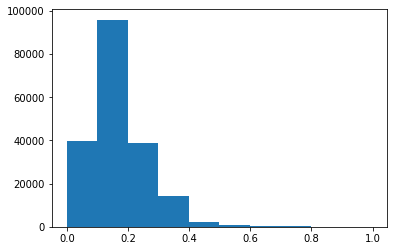

In [31]:
plt.hist(pred.detach().numpy())

In [32]:
# final output requires values in [0,1]
# pscale = (p - np.min(p)) / (np.max(p)-np.min(p))
out = pd.DataFrame({"id":test_o.iloc[:,0], "Predicted":pred.detach().numpy()})

with open("stockrdige.csv", "w") as f:
    f.write(out.to_csv(index=False))

In [33]:
out

id  Predicted
0       592380   0.314543
1       592381   0.105761
2       592382   0.224414
3       592383   0.372043
4       592384   0.219840
...        ...        ...
191854  784234   0.153403
191855  784235   0.045649
191856  784236   0.178071
191857  784237   0.172793
191858  784238   0.087067

[191859 rows x 2 columns]

In [34]:
out.to_csv(index=False)

'id,Predicted\r\n592380,0.31454283\r\n592381,0.10576083\r\n592382,0.22441356\r\n592383,0.37204328\r\n592384,0.21983977\r\n592385,0.09894244\r\n592386,0.10860925\r\n592387,0.12252999\r\n592388,0.13302581\r\n592389,0.11637121\r\n592390,0.099048495\r\n592391,0.09321789\r\n592392,0.32006893\r\n592393,0.2565999\r\n592394,0.21582325\r\n592395,0.2242892\r\n592396,0.2221554\r\n592397,0.10208193\r\n592398,0.06904439\r\n592399,0.27243733\r\n592400,0.09943108\r\n592401,0.13732503\r\n592402,0.14289533\r\n592403,0.15952598\r\n592404,0.10956348\r\n592405,0.15429433\r\n592406,0.12641425\r\n592407,0.20371114\r\n592408,0.11125245\r\n592409,0.16000459\r\n592410,0.15097016\r\n592411,0.16735081\r\n592412,0.13981937\r\n592413,0.16471435\r\n592414,0.072516225\r\n592415,0.22768241\r\n592416,0.14921293\r\n592417,0.37204328\r\n592418,0.2276201\r\n592419,0.1041159\r\n592420,0.121139154\r\n592421,0.15251987\r\n592422,0.13082482\r\n592423,0.22658862\r\n592424,0.12337054\r\n592425,0.16363947\r\n592426,0.4144699\r\